# Time series Analysis of Returns from Ripple

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import seaborn as sns

In [2]:
returns=pd.read_excel(r'/Users/radhikagarg/Desktop/data/monthly_returns_collated.xlsx')
print(returns.tail())

        Month   Bitcoin   Cardano  Ethereum  Litecoin    Ripple
33 2020-10-01  0.008171 -0.002348  0.002661  0.006535 -0.000097
34 2020-11-01  0.012607  0.022603  0.016657  0.017310  0.039680
35 2020-12-01  0.013084  0.003652  0.006648  0.013435 -0.027897
36 2021-01-01  0.005806  0.025213  0.022081  0.003681  0.032526
37 2021-02-01  0.012504  0.052857  0.004111  0.011071 -0.002661


<AxesSubplot:>

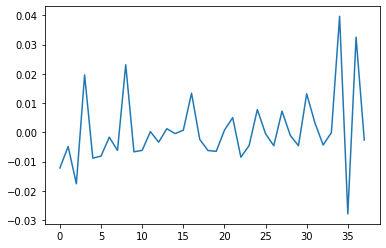

In [3]:
returns['Ripple'].plot()

In [4]:
import datetime
returns['Month']=pd.to_datetime(returns['Month']) # setting month as index to exclude month from describe calcs
returns.head()
returns.describe()

,Bitcoin,Cardano,Ethereum,Litecoin,Ripple
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.001860,0.002559,0.001940,0.001304,0.000465
std,0.007238,0.014835,0.010524,0.009222,0.012556
min,-0.013957,-0.022140,-0.024330,-0.014840,-0.027897
25%,-0.002529,-0.005902,-0.005402,-0.006230,-0.006176
50%,0.000163,-0.001057,0.002204,0.000519,-0.002057
75%,0.007931,0.008596,0.008018,0.009405,0.002725
max,0.016413,0.052857,0.022081,0.017481,0.039680


In [5]:
returns.set_index('Month',inplace=True)

In [6]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(returns['Ripple'], autolag='AIC')
print(dftest)

Results of Dickey-Fuller Test:
(-10.029251153528632, 1.6011999933947173e-17, 0, 37, {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}, -166.58736082197382)


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    # Super not sure how to determin this... We'll have to do some research
    # 7 to 14 days seems reasonable to find overall trends
    rolmean = pd.Series(timeseries).rolling(window=14).mean()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

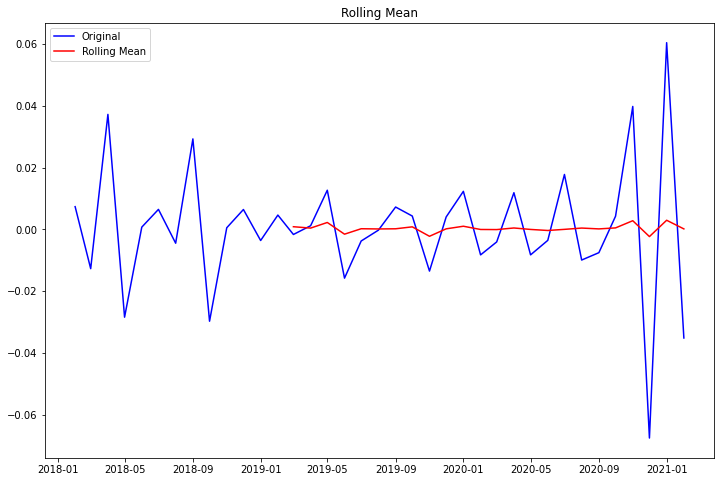

Results of Dickey-Fuller Test:
Test Statistic                -7.294314e+00
p-value                        1.390801e-10
#Lags Used                     2.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64


In [8]:
#prev 1 month dependency is  seen
returns['first_difference'] = returns['Ripple'] - returns['Ripple'].shift(1)  
test_stationarity(returns.first_difference.dropna(inplace=False))

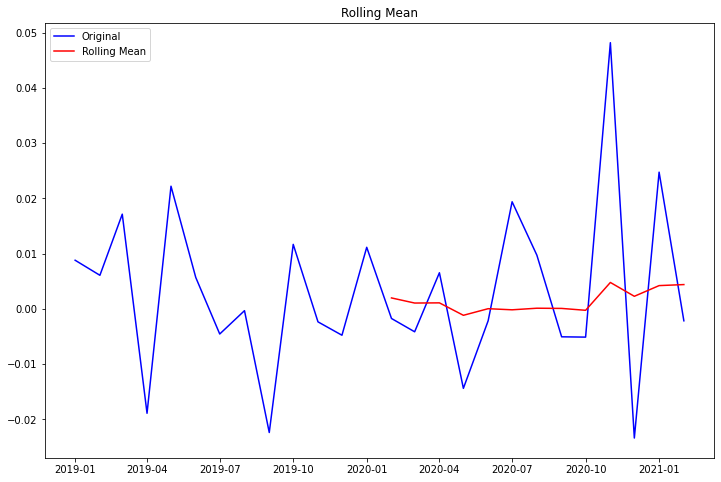

Results of Dickey-Fuller Test:
Test Statistic                -8.258095e+00
p-value                        5.171302e-13
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64


In [10]:
#seasonal first dependency is seen
returns['seasonal_first_difference']=returns['Ripple']-returns['Ripple'].shift(12) # ar 1 but prev year value of same month or day/ or 12 month prev value
test_stationarity(returns.seasonal_first_difference.dropna(inplace=False))

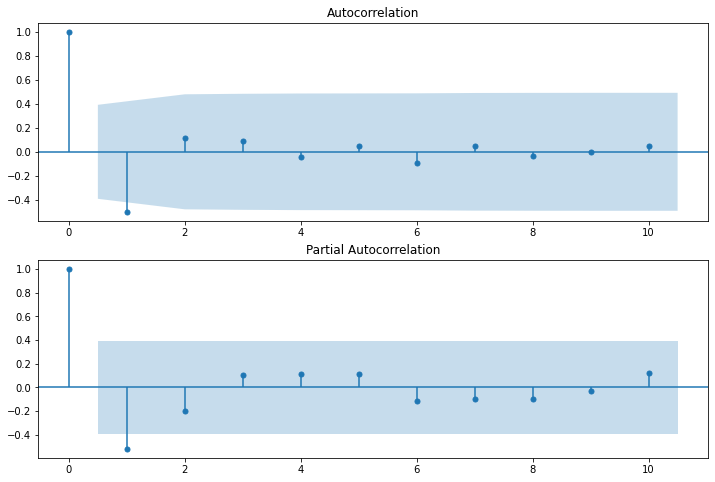

In [12]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returns['seasonal_first_difference'].iloc[13:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(returns['seasonal_first_difference'].iloc[13:], lags=10, ax=ax2)
plt.show()

#p=2,
#d=1,
#q=2,

In [13]:
returns.head()

,Bitcoin,Cardano,Ethereum,Litecoin,Ripple,first_difference,seasonal_first_difference
Month,,,,,,,
2018-01-01,-0.007661,-0.003929,0.016658,-0.008313,-0.012184,NaN,NaN
2018-02-01,0.002750,-0.013925,-0.007186,0.012329,-0.004850,0.007334,NaN
2018-03-01,-0.012540,-0.022140,-0.024330,-0.014840,-0.017590,-0.012740,NaN
2018-04-01,0.010590,0.032210,0.019400,0.009660,0.019617,0.037207,NaN
2018-05-01,-0.006310,-0.011832,-0.003442,-0.006365,-0.008835,-0.028452,NaN


In [63]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(returns['Ripple'],order=(1,1,0))
model_fit=model.fit()

#Based on the model summary, all variables (ar and ma) have a p-value <5%. This means that our model 
#really fits into the train data. The AIC, BIC, and HQIC is a score to measure the goodness of our model based on 
#the train data.

/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was p

In [64]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Bitcoin   No. Observations:                   35
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 119.586
Method:                       css-mle   S.D. of innovations              0.008
Date:                Wed, 07 Apr 2021   AIC                           -233.171
Time:                        15:07:08   BIC                           -228.505
Sample:                    04-01-2018   HQIC                          -231.561
                         - 02-01-2021                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001      0.490      0.624      -0.001       0.002
ar.L1.D.Bitcoin    -0.4696      0.166     -2.821      0.005      -0.796      -0.143
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1296           +0.0000j            2.1296            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:ylabel='Density'>

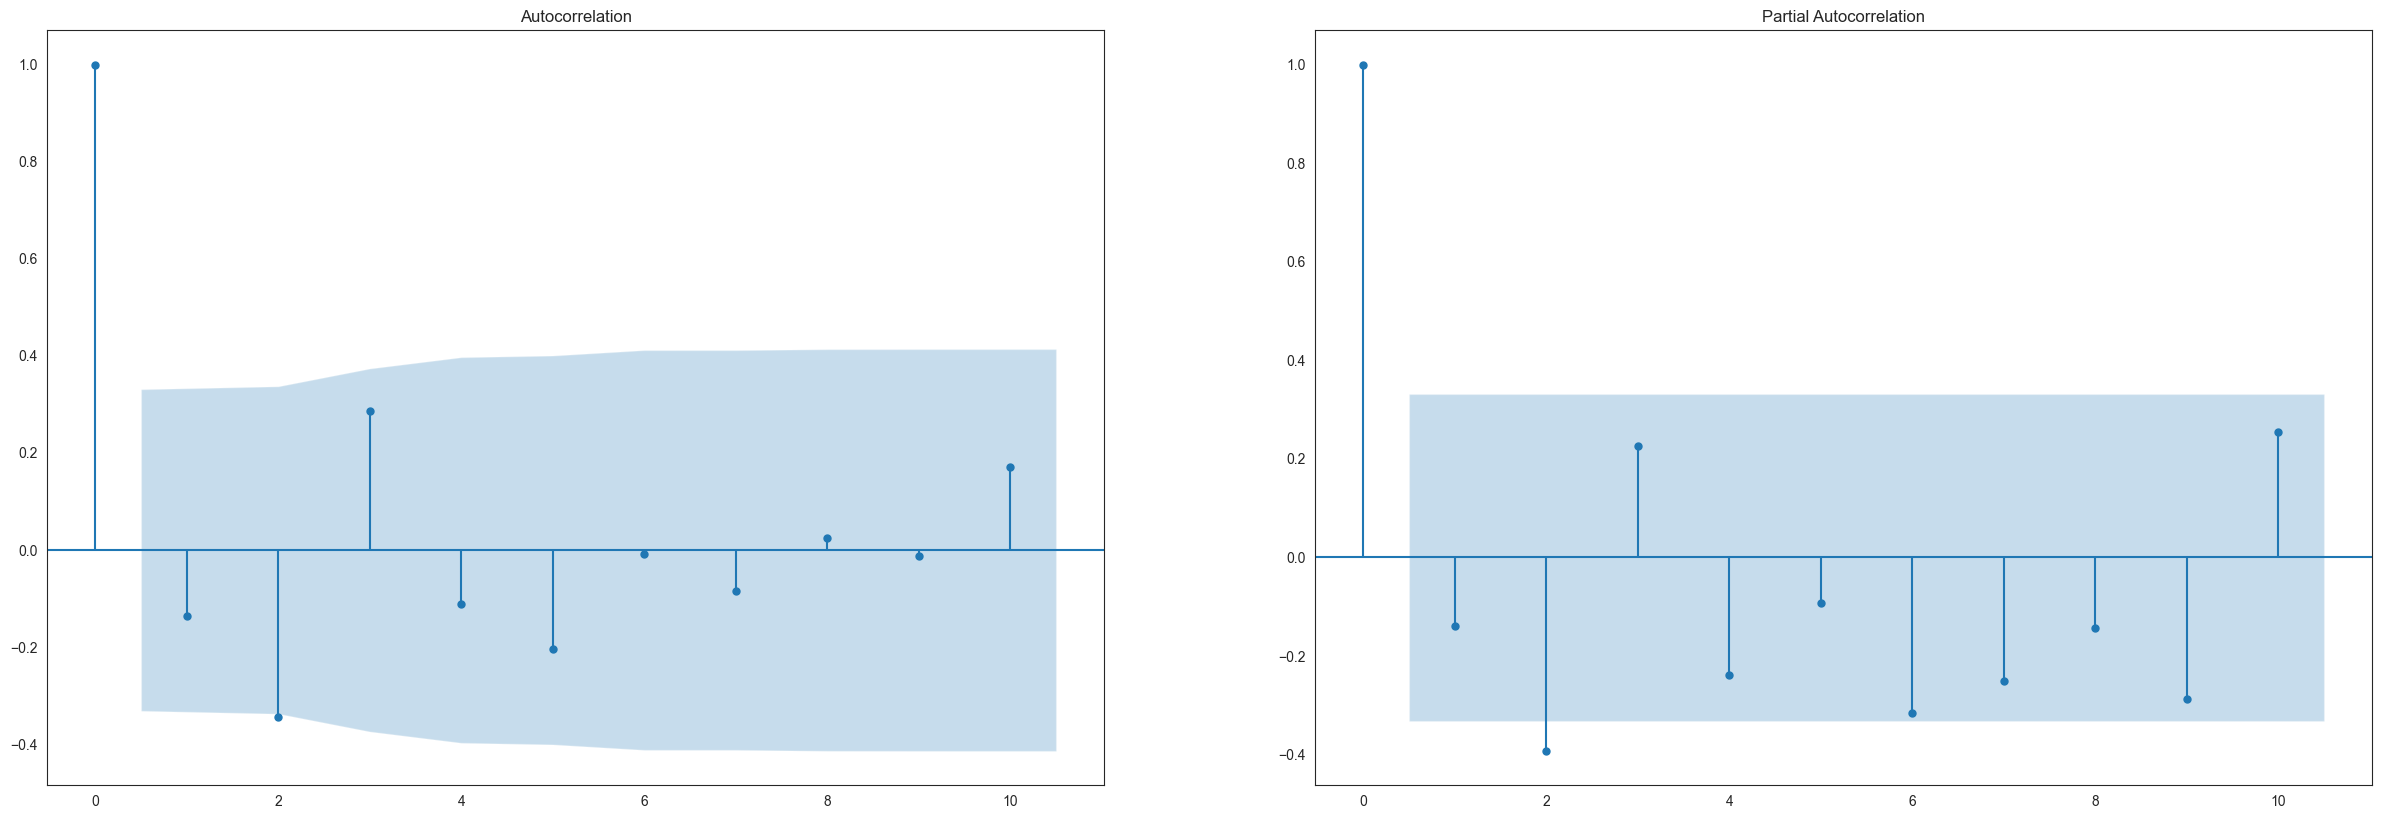

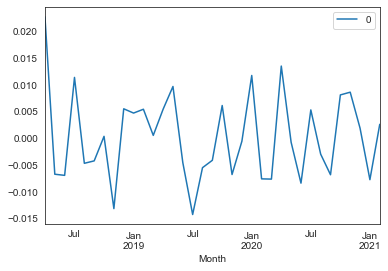

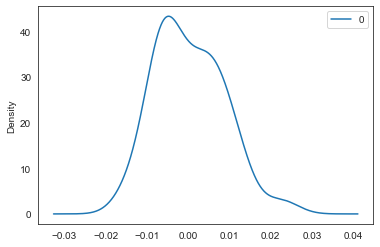

In [65]:
#residual behavior
residuals = pd.DataFrame(model_fit.resid)
fig, axes = plt.subplots(1,2,figsize=(30,10), dpi= 100)
sm.graphics.tsa.plot_acf(residuals, lags=10, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals, lags=10, ax=axes[1])
residuals.plot()
residuals.plot(kind='kde')
#Now that we have our models, we don’t want the residuals to have autocorrelation. 
#Thus, let’s try to see the ACF-PACF values for each residual lag.

In [17]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(returns['Ripple'], start_p = 1, start_q = 1, 
                          max_p = 1, max_q = 2, m = 1, 
                          start_P = 0, seasonal = False, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',    # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

#https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html
#https://alkaline-ml.com/pmdarima/0.9.0/tips_and_tricks.html#period

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-220.455, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-175.423, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-201.599, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-177.418, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-216.554, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-225.759, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-225.173, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.299 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 116.880
Date:                Wed, 07 Apr 2021   AIC                           -225.759
Time:                        18:30:41   BIC                           -219.316
Sample:                             0   HQIC                          -223.488
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.317      0.188      -0.000       0.001
ma.L1         -1.6149      0.223     -7.248      0.000      -2.052      -1.178
ma.L2          0.7724      0.226      3.423      0.001       0.330       1.215
sigma2      9.587e-05   3.64e-05      2.635      0.008    2.46e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 7.33
Prob(Q):                              0.62   Prob(JB):                         0.03
Heteroskedasticity (H):               1.30   Skew:                             1.01
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


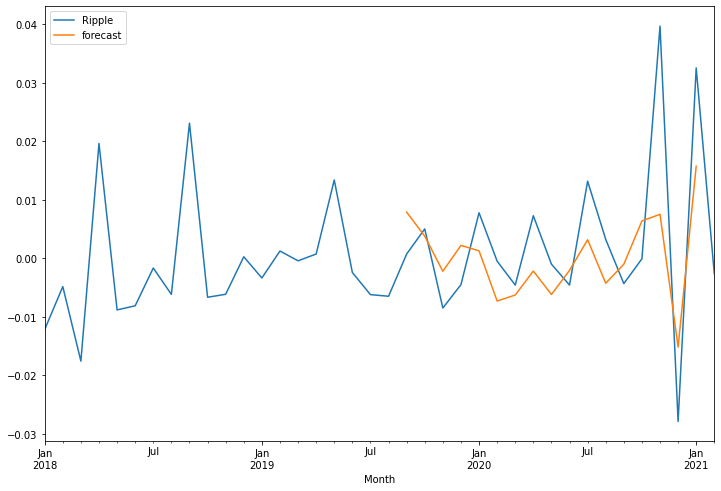

In [21]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(returns['Ripple'],order=(0,1,2),seasonal_order=(0,0,0,0))
model_fit=model.fit()
returns['forecast']=model_fit.predict(start=20,end=36,dynamic=False)
returns[['Ripple','forecast']].plot(figsize=(12,8))
plt.show()

In [22]:
from pandas.tseries.offsets import DateOffset

future_dates=[returns.index[-1]+DateOffset(months=x) for x in range(0,24)]
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=returns.columns)
future_dates_df.tail()

,Bitcoin,Cardano,Ethereum,Litecoin,Ripple,first_difference,seasonal_first_difference,forecast
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

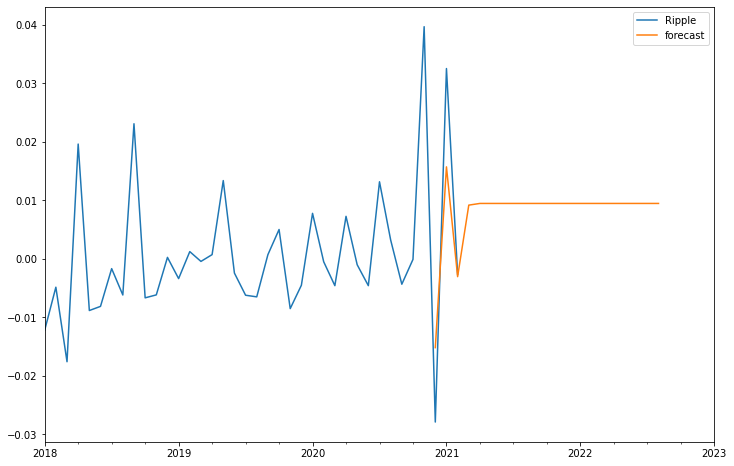

In [23]:
future_df=pd.concat([returns,future_dates_df])
future_df['forecast']=model_fit.predict(start=35,end=55,dynamic=False)
future_df[['Ripple','forecast']].plot(figsize=(12,8))

In [24]:
from sklearn.model_selection import TimeSeriesSplit
data = pd.DataFrame(returns['Ripple'])

#Specify fold and perform splitting
tscv = TimeSeriesSplit(n_splits=3)

#Find out no of observations in train and test sets
i=0
for train, test in tscv.split(data):
    i=i+1
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

No of observations under train1=11
No of observations under test1=9
No of observations under train2=20
No of observations under test2=9
No of observations under train3=29
No of observations under test3=9


In [25]:
train1, test1 = data.iloc[:11, 0], data.iloc[11:20, 0]
train2, test2 = data.iloc[:20, 0], data.iloc[20:29, 0]
train3, test3 = data.iloc[:29, 0], data.iloc[29:38, 0]

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#First fold RMSE
model1 = sm.tsa.statespace.SARIMAX(train1, order=(1,1,0)).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#Second fold RMSE
model2 = sm.tsa.statespace.SARIMAX(train2, order=(1,1,0)).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
RMSE2=round(sqrt(mean_squared_error(test2, pred2)),2)

#Third fold RMSE
model3 = sm.tsa.statespace.SARIMAX(train3, order=(1,1,0)).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
RMSE3=round(sqrt(mean_squared_error(test3, pred3)),2)

print ("RMSE1:", RMSE1)
print ("RMSE2:", RMSE2)
print ("RMSE3:", RMSE3)

Overall_RMSE=round((RMSE1+RMSE2+RMSE3)/3,2)
print ("Overall RMSE:", Overall_RMSE) 



RMSE1: 0.01
RMSE2: 0.01
RMSE3: 0.02
Overall RMSE: 0.01


/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/radhikagarg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/radhikagarg/opt/anaconda3/lib/python3

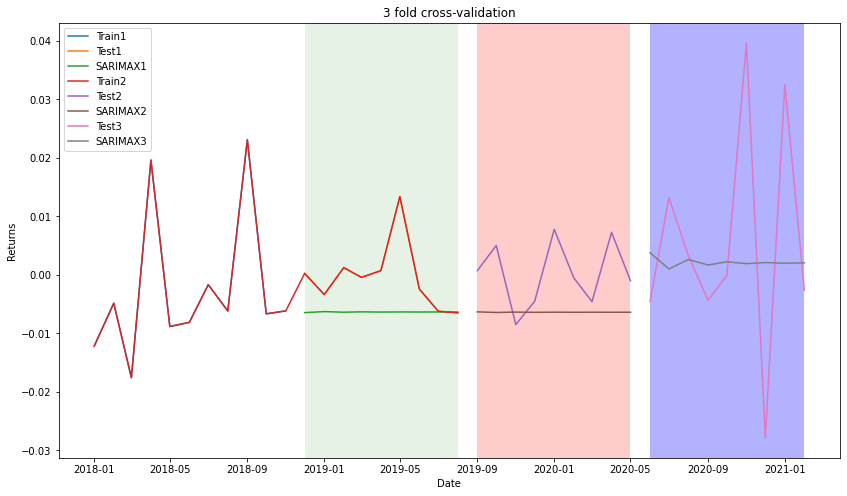

In [27]:
#plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
plt.plot(pred1.index, pred1, label='SARIMAX1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
plt.plot(pred2.index, pred2, label='SARIMAX2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='SARIMAX3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)